# Factor Model of Portfolio Return


In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [4]:
import os
import quiz_helper
from zipline.data import bundles

In [5]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [6]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [7]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

In [8]:
len(universe_tickers)

490

In [9]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [10]:
from quiz_helper import get_pricing

## get pricing data into a dataframe

In [11]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Let's look at a two stock portfolio

Let's pretend we have a portfolio of two stocks.  We'll pick Apple and Microsoft in this example.

In [12]:
aapl_col = returns_df.columns[3]
msft_col = returns_df.columns[312]
asset_return_1 = returns_df[aapl_col].rename('asset_return_aapl')
asset_return_2 = returns_df[msft_col].rename('asset_return_msft')
asset_return_df = pd.concat([asset_return_1,asset_return_2],axis=1)
asset_return_df.head(2)

,asset_return_aapl,asset_return_msft
2011-01-07 00:00:00+00:00,0.007146,-0.007597
2011-01-10 00:00:00+00:00,0.018852,-0.013311


## Factor returns
Let's make up a "factor" by taking an average of all stocks in our list.  You can think of this as an equal weighted index of the 490 stocks, kind of like a measure of the "market".  We'll also make another factor by calculating the median of all the stocks.  These are mainly intended to help us generate some data to work with.  We'll go into how some common risk factors are generated later in the lessons.

Also note that we're setting axis=1 so that we calculate a value for each time period (row) instead of one value for each column (assets).

In [13]:
factor_return_1 = returns_df.mean(axis=1)
factor_return_2 = returns_df.median(axis=1)
factor_return_l = [factor_return_1, factor_return_2]

## Factor exposures

Factor exposures refer to how "exposed" a stock is to each factor.  We'll get into this more later.  For now, just think of this as one number for each stock, for each of the factors.

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
"""
For now, just assume that we're calculating a number for each 
stock, for each factor, which represents how "exposed" each stock is
to each factor. 
We'll discuss how factor exposure is calculated later in the lessons.
"""
def get_factor_exposures(factor_return_l, asset_return):
    lr = LinearRegression()
    X = np.array(factor_return_l).T
    y = np.array(asset_return.values)
    lr.fit(X,y)
    return lr.coef_

In [16]:
factor_exposure_l = []
for i in range(len(asset_return_df.columns)):
    factor_exposure_l.append(
        get_factor_exposures(factor_return_l,
                             asset_return_df[asset_return_df.columns[i]]
                            ))
    
factor_exposure_a = np.array(factor_exposure_l)

In [17]:
print(f"factor_exposures for asset 1 {factor_exposure_a[0]}")
print(f"factor_exposures for asset 2 {factor_exposure_a[1]}")

factor_exposures for asset 1 [ 1.35101534 -0.58353198]
factor_exposures for asset 2 [-0.2283345   1.16364007]


In [28]:
factor_exposure_a

array([[ 1.35101534, -0.58353198],
       [-0.2283345 ,  1.16364007]])

## Quiz 1 Portfolio's factor exposures

Let's make up some portfolio weights for now; in a later lesson, we'll look at how portfolio optimization combines alpha factors and a risk factor model to choose asset weights.

$\beta_{p,k} = \sum_{i=1}^{N}(x_i \times \beta_{i,k})$

In [18]:
weight_1 = 0.60 #let's give AAPL a portfolio weight
weight_2 = 0.40 #give MSFT a portfolio weight
weight_a = np.array([weight_1, weight_2])

In [25]:
weight_a.dot(factor_exposure_a)

array([0.71927541, 0.11533684])

For the sake of understanding, try saving each of the values
into a separate variable to perform the multipliations and additions
Check that your calculations for portfolio factor exposure match
the output of this dot product:
```
weight_a.dot(factor_exposure_a)
```

In [58]:
# TODO: calculate portfolio's exposure to factor 1
factor_exposure_1_1 = factor_exposure_a[0][0]# ...
factor_exposure_2_1 = factor_exposure_a[1][0]# ...
factor_exposure_p_1 = weight_1 * factor_exposure_1_1 + weight_2 * factor_exposure_2_1# ...
factor_exposure_p_1

0.7192754067760122

In [59]:
# TODO: calculate portfolio's exposure to factor 2
factor_exposure_1_2 = factor_exposure_a[0][1]# ...
factor_exposure_2_2 = factor_exposure_a[1][1]# ...
factor_exposure_p_2 = weight_1 * factor_exposure_1_2 + weight_2 * factor_exposure_2_2# ...
factor_exposure_p_2

0.11533683816249468

## Quiz 2 Calculate portfolio return

For clarity, try storing the pieces into their own 
named variables and writing out the multiplications and addition.

You can check if your answer matches this output:
```
asset_return_df.values.dot(weight_a)
```

In [31]:
asset_return_df.values.dot(weight_a)

array([ 0.00124922,  0.00598668, -0.00297205, ..., -0.01741331,
       -0.00439135, -0.01320733])

In [54]:
# TODO calculate the portfolio return
asset_return_1 = asset_return_df.values.T[0] # ...
asset_return_2 = asset_return_df.values.T[1] # ...
portfolio_return = asset_return_1 *weight_1 + asset_return_2 *weight_2# ...

portfolio_return = pd.Series(portfolio_return,index=asset_return_df.index).rename('portfolio_return')
portfolio_return.head(2)

2011-01-07 00:00:00+00:00    0.001249
2011-01-10 00:00:00+00:00    0.005987
Freq: C, Name: portfolio_return, dtype: float64

## Quiz 3 Contribution of Factors

The sum of the products of factor exposure times factor return is the contribution of the factors.  It's also called the "common return." calculate the common return of the portfolio, given the two factor exposures and the two factor returns.

In [55]:
# TODO: Calculate the contribution of the two factors to the return of this example asset
common_return = factor_exposure_p_1 * factor_return_1 + factor_exposure_p_2 * factor_return_2 # ...
common_return = common_return.rename('common_return')

common_return.head(2)

2011-01-07 00:00:00+00:00    0.000051
2011-01-10 00:00:00+00:00    0.000269
Freq: C, Name: common_return, dtype: float64

## Quiz 4 Specific Return
The specific return is the part of the portfolio return that isn't explained by the factors.  So it's the actual return minus the common return.  
Calculate the specific return of the stock.

In [56]:
# TODO: calculate the specific return of this asset
specific_return = portfolio_return - common_return # ...
specific_return = specific_return.rename('specific_return')

## Visualize the common return and specific return


In [57]:
return_components = pd.concat([common_return,specific_return],axis=1)
return_components.head(2)

,common_return,specific_return
2011-01-07 00:00:00+00:00,0.000051,0.001198
2011-01-10 00:00:00+00:00,0.000269,0.005717


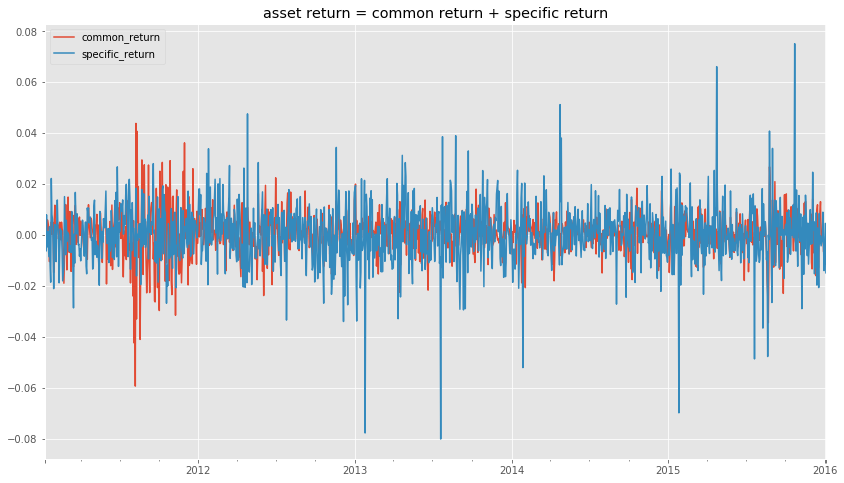

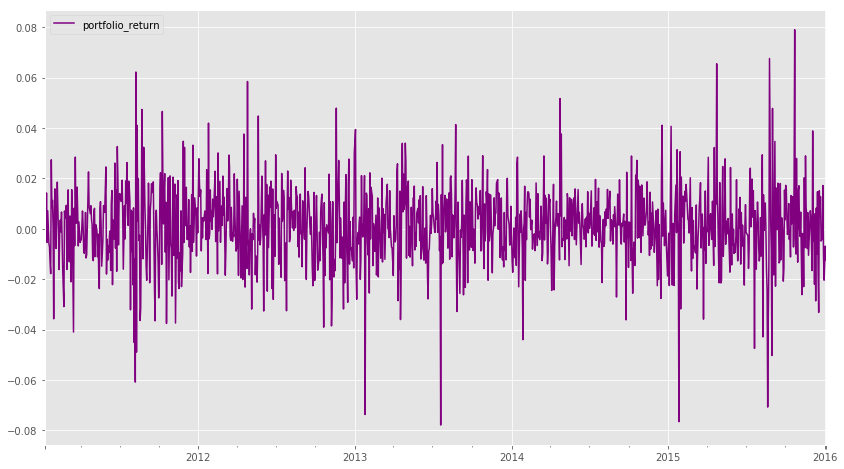

In [53]:
return_components.plot(title="asset return = common return + specific return");
pd.DataFrame(portfolio_return).plot(color='purple');

## Solution
[Solution notebook](factor_model_portfolio_return_solution.ipynb)